In [1]:
"""
Follows https://www.tensorflow.org/tutorials/text/text_classification_rnn
"""
import pickle as pkl
import numpy as np
import random
import re

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
datetime.now()
EXP_NUM = 17

In [3]:
def plot_graphs(history, metric):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(metric, color=color)
    ax1.plot(history.history[metric], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel("val_" + metric, color=color)  # we already handled the x-label with ax1
    ax2.plot(history.history["val_" + metric], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend([metric, "val_" + metric])

In [4]:
def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)

In [5]:
def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'

In [6]:
def clean_copy(data, min_length = 10):
    cleaned_data = np.fromiter((x for x in data if len(x["synopsis"].split()) > min_length), dtype=data.dtype)
    print(f"Crushed {len(data)} to {len(cleaned_data)} after removing sub {min_length} word synopses")
    return cleaned_data

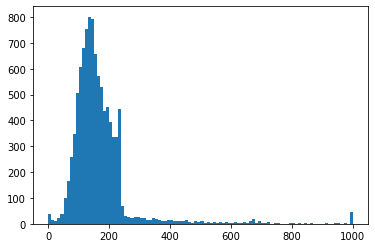

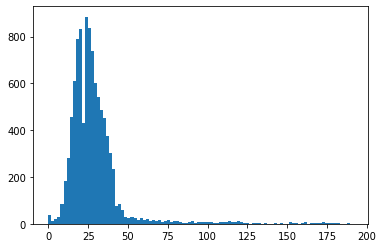

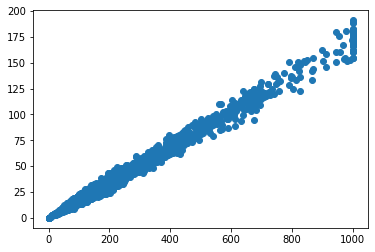

In [7]:
raw_data = pkl.load(open("complete10000_films_and_synopsis.pickle", "rb"))
plt.figure()
word_stats = [(len(x["synopsis"]),len(x["synopsis"].split())) for x in raw_data]
plt.hist([a for a,_ in word_stats], label="characters", bins=100)
plt.figure()
plt.hist([a for _,a in word_stats], label="words", bins=100)
plt.figure()
plt.scatter([a for a,_ in word_stats],[a for _,a in word_stats])

In [8]:
real_data = clean_copy(raw_data)
np.random.shuffle(real_data[500:])
data = real_data

Crushed 10000 to 9742 after removing sub 10 word synopses


In [9]:
# Fraction of overall data
training_fraction = 0.85

train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))


# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

In [10]:
sample, label = next(iter(train_dataset.take(1)))

In [11]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams=1
)


In [12]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [13]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[   1    1    9    7  611  412   10   66 7205    1    1  365  108   75
     3 4577    1 2796   21 8732  372  517    7    3    1  390  214   13
     2 9201   18    3 2152 4110  640 9554    3  508 3015   13    3   42
     5 1665  640    1   14   12 5910 1048 7161  640 9935 6351   22   12
   413  417 4385  498   12   33  196   10    3    1 4057  640    1  592
    28   36  360  950   22 4057    9  354  193    4  162   28    9  253
     7    3  681    5 1595    1   11  743 5529   10    2    1   14 3075
     6  157   71 3703    4    3  532    6  417 4789    5 1049]
 [   2  653 3540   41  450    1   20    3  626 6041   23    3  380 1052
  9585   12  133    7    3 9945    7   66  332    5  673   19   28    9
  1419   18  130 2100    5    3    1    6  317    1    6    1  193   20
     3 1594    3 5151    9  219 3525   10    2  213   27    3 1519  626
   632   92    3    1 2525  901    7  131 2841    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
 

In [14]:
vocab = np.array(encoder.get_vocabulary())

for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b"Bertrand Tavernier is in top form with this gripping, superbly mounted drama set against the savage Catholic/Protestant wars that ripped France apart in the 16th century. Based on a novella by the celebrated Madame de Lafayette, the action centers on the love of Marie de Mezi\xc3\xa8res for her dashing cousin Henri de Guise, thwarted when her father's political ambitions force her into marriage with the well-connected Philippe de Montpensier, whom she has never met. When Philippe is called away to fight, she is left in the care of Count Chabannes, an aging nobleman with a disdain for warfare, and soon becomes exposed to the sexual and political intrigues of court."
Round-trip:  [UNK] [UNK] is in top form with this gripping [UNK] [UNK] drama set against the savage [UNK] wars that ripped france apart in the [UNK] century based on a novella by the celebrated madame de lafayette the action centers on the love of marie de [UNK] for her dashing cousin henri de guise thwarted whe

In [15]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.1),
)

In [ ]:
history = model.fit(
    train_dataset, epochs=100, validation_data=test_dataset, validation_steps=len(test_data_in) // BATCH_SIZE
)

Epoch 1/100
130/130 [==============================] - 26s 200ms/step - loss: 3951649890500608.0000 - val_loss: 819849127264256.0000
Epoch 2/100
130/130 [==============================] - 22s 170ms/step - loss: 3553005253165056.0000 - val_loss: 818209456390144.0000
Epoch 3/100
130/130 [==============================] - 22s 171ms/step - loss: 3486854435307520.0000 - val_loss: 801150383161344.0000
Epoch 4/100
130/130 [==============================] - 22s 171ms/step - loss: 3418136837619712.0000 - val_loss: 963662953054208.0000
Epoch 5/100
130/130 [==============================] - 22s 171ms/step - loss: 3362835912458240.0000 - val_loss: 906997838905344.0000
Epoch 6/100
130/130 [==============================] - 22s 170ms/step - loss: 3297144387665920.0000 - val_loss: 1016500043382784.0000
Epoch 7/100
130/130 [==============================] - 21s 165ms/step - loss: 3259862729359360.0000 - val_loss: 929762440642560.0000
Epoch 8/100
130/130 [==============================] - 23s 173ms/ste

In [ ]:
res = model.evaluate(test_dataset)

In [ ]:
sample_text = "As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace."
pred1 = model.predict(np.array([sample_text]))
print(int(pred1[0]))

In [ ]:
non_existant_film = "Este is a friend of mine we meet up every tuesday night for dinner and a glass of wine. She thinks he did it but just cant prove it"
pred2 = model.predict(np.array([non_existant_film]))
print(int(pred2[0]))

In [ ]:
def confusion_plot(lab, pred, name, new_plot=False, save=False):
    """
    lab = label
    pred = prediction
    """
    if new_plot:
        plt.figure()
    plt.scatter(lab, lab, label='truth', s=2, color='black')
    plt.scatter(lab, pred, label=name, s=2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.xlabel('Truth')
    plt.ylabel('Prediction')
    if save:
        plt.savefig(f"exp_{EXP_NUM}.png", dpi=300)



In [ ]:
test_predictions = model.predict(test_data_in)
train_predictions = model.predict(train_data_in)
confusion_plot(train_data_out, train_predictions, 'train')
confusion_plot(test_data_out, test_predictions, 'test')
plt.show()
plt.savefig("exp_{EXP_NUM}.pdf", dpi=300)

In [ ]:
for min_words in [0, 10, 25, 50]:
    data_in, data_out = split_data_into_input_and_output(clean_copy(raw_data, min_words))
    predictions = model.predict(data_in)
    confusion_plot(data_out, predictions, f'{min_words}')

In [ ]:
plot_graphs(history,'loss')
plt.savefig("exp_14_2.pdf", dpi=300)

In [ ]:
histories = dict()
models = dict()
experiment_cutoffs = [0,10,25,50]
for min_words in experiment_cutoffs:
    data = clean_copy(raw_data, min_words)
    
    # Fraction of overall data
    training_fraction = 0.85
    train_end = int(len(data) * training_fraction)
    train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
    test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])
    
    # Make dataset objects
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))

    # Shuffle
    # How much it loads into memory for sampling
    BUFFER_SIZE = 10000
    # Batch for gradient averaging
    BATCH_SIZE = 64
    # prefetch parrallelising loading + execution (not huge so not necessary)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)
    
    # Specify encoding of words
    SUBSET_VOCAB_SIZE = 10000
    encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=SUBSET_VOCAB_SIZE, ngrams=1
    )
    encoder.adapt(train_dataset.map(lambda text, label: text))
    
    # Specify overall architecture
    models[min_words] = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
    )
    models[min_words].compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(0.1),
    )

    # Train
    histories[min_words] = models[min_words].fit(
    train_dataset, epochs=100, validation_data=test_dataset, validation_steps=len(test_data_in) // BATCH_SIZE
    )
    
    # Look at performance
    pred = models[min_words].predict(train_data_in)
    confusion_plot(train_data_out, pred, f'{min_words}')

In [ ]:
for a in experiment_cutoffs:
    plot_graphs(histories[a],'loss')